In [1]:
import matplotlib.pyplot as plt
import json
import itertools
import pandas as pd
import numpy as np

In [2]:
with open('results_test.json') as f:
    data = json.load(f)
    
data_list = []

for run_idx, run in enumerate(data):
    for planner_run in run['planner_runs']:
        data_list.append({
            'run_idx': run_idx,
            'apples': run['number_of_apples'],
            **planner_run
        })
            
data_df = pd.DataFrame(data_list).sort_values('run_idx')
data_df['mean_per_target_path_length'] = data_df.total_path_length / data_df.apples
data_df = data_df.set_index(['run_idx','intermediate_planner','order_planning', 'optimization_objective'])

In [3]:
data_df

apples  \
run_idx intermediate_planner order_planning optimization_objective           
0       PRMstar              NN+Prob2OPT    Path Length                 95   
                             1-NN           Path Length                 95   
                             2-NN           Path Length                 95   
                             3-NN           Path Length                 95   
                             U-1-NN         Path Length                 95   
...                                                                    ...   
9       PRMstar              1-NN           Path Length                 61   
                             2-NN           Path Length                 61   
                             3-NN           Path Length                 61   
                             U-1-NN         Path Length                 61   
                             U-3-NN         Path Length                 61   

                                                                                            leaf_collisions_over_time  \
run_idx intermediate_planner order_planning optimization_objective                                                      
0       PRMstar              NN+Prob2OPT    Path Length             [{'contacts_ended': 0, 'new_leaves_in_contact'...   
                             1-NN           Path Length             [{'contacts_ended': 0, 'new_leaves_in_contact'...   
                             2-NN           Path Length             [{'contacts_ended': 0, 'new_leaves_in_contact'...   
                             3-NN           Path Length             [{'contacts_ended': 0, 'new_leaves_in_contact'...   
                             U-1-NN         Path Length             [{'contacts_ended': 0, 'new_leaves_in_contact'...   
...                                                                                                               ...   
9       PRMstar              1-NN           Path Length             [{'contacts_ended': 0, 'new_leaves_in_contact'...   
                             2-NN           Path Length             [{'contacts_ended': 0, 'new_leaves_in_contact'...   
                             3-NN           Path Length             [{'contacts_ended': 0, 'new_leaves_in_contact'...   
                             U-1-NN         Path Length             [{'contacts_ended': 0, 'new_leaves_in_contact'...   
                             U-3-NN         Path Length             [{'contacts_ended': 0, 'new_leaves_in_contact'...   

                                                                    targets_visited  \
run_idx intermediate_planner order_planning optimization_objective                    
0       PRMstar              NN+Prob2OPT    Path Length                          95   
                             1-NN           Path Length                          95   
                             2-NN           Path Length                          95   
                             3-NN           Path Length                          95   
                             U-1-NN         Path Length                          95   
...                                                                             ...   
9       PRMstar              1-NN           Path Length                          61   
                             2-NN           Path Length                          61   
                             3-NN           Path Length                          61   
                             U-1-NN         Path Length                          61   
                             U-3-NN         Path Length                          61   

                                                                    total_path_length  \
run_idx intermediate_planner order_planning optimization_objective                      
0       PRMstar              NN+Prob2OPT    Path Length                   3021.977318   
                             1-NN           Path Length                   3011.0

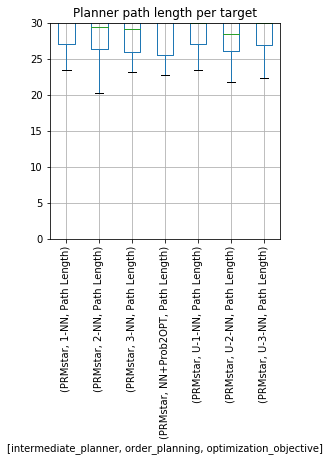

In [4]:
(data_df.total_path_length / data_df.targets_visited)\
    .to_frame()\
    .boxplot(by=['intermediate_planner','order_planning', 'optimization_objective'], rot=90, figsize=(4,4))

plt.ylim(0,30)
plt.title('Planner path length per target')
plt.suptitle('')
plt.savefig('path_length_per_target.png')
plt.show()

In [5]:
data_df[data_df.apples < 50]

apples  \
run_idx intermediate_planner order_planning optimization_objective           
1       PRMstar              U-3-NN         Path Length                 39   
                             U-2-NN         Path Length                 39   
                             U-1-NN         Path Length                 39   
                             1-NN           Path Length                 39   
                             2-NN           Path Length                 39   
                             NN+Prob2OPT    Path Length                 39   
                             3-NN           Path Length                 39   
2       PRMstar              U-2-NN         Path Length                 31   
                             U-3-NN         Path Length                 31   
                             U-1-NN         Path Length                 31   
                             1-NN           Path Length                 31   
                             2-NN           Path Length                 31   
                             NN+Prob2OPT    Path Length                 31   
                             3-NN           Path Length                 31   
5       PRMstar              U-2-NN         Path Length                 32   
                             U-1-NN         Path Length                 32   
                             3-NN           Path Length                 32   
                             U-3-NN         Path Length                 32   
                             1-NN           Path Length                 32   
                             NN+Prob2OPT    Path Length                 32   
                             2-NN           Path Length                 32   
6       PRMstar              NN+Prob2OPT    Path Length                 42   
                             1-NN           Path Length                 42   
                             2-NN           Path Length                 42   
                             3-NN           Path Length                 42   
                             U-1-NN         Path Length                 42   
                             U-2-NN         Path Length                 42   
                             U-3-NN         Path Length                 42   
7       PRMstar              U-3-NN         Path Length                 41   
                             U-2-NN         Path Length                 41   
                             U-1-NN         Path Length                 41   
                             1-NN           Path Length                 41   
                             2-NN           Path Length                 41   
                             NN+Prob2OPT    Path Length                 41   
                             3-NN           Path Length                 41   
8       PRMstar              U-3-NN         Path Length                 22   
                             U-1-NN         Path Length                 22   
                             3-NN           Path Length                 22   
                             U-2-NN         Path Length                 22   
                             1-NN           Path Length                 22   
                             NN+Prob2OPT    Path Length                 22   
                             2-NN           Path Length                 22   

                                                                                            leaf_collisions_over_time  \
run_idx intermediate_planner order_planning optimization_objective                                                      
1       PRMstar              U-3-NN         Path Length             [{'contacts_ended': 0, 'new_leaves_in_contact'...   
                             U-2-NN         Path Length             [{'contacts_ended': 0, 'new_leaves_in_contact'...   
                             U-1-NN         Path Length             [{'contacts_ended': 0, 'new_leaves_in_contact'...   
                             1

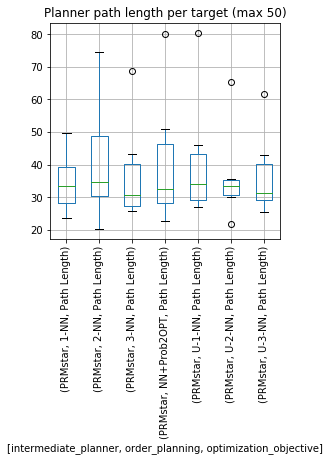

In [9]:
dlow = data_df[data_df.apples < 50]

(dlow.total_path_length / dlow.targets_visited)\
    .to_frame()\
    .boxplot(by=['intermediate_planner','order_planning', 'optimization_objective'], rot=90, figsize=(4,4))

# plt.ylim(0,30)
plt.title('Planner path length per target (max 50)')
plt.suptitle('')
plt.savefig('path_length_per_target.png')
plt.show()

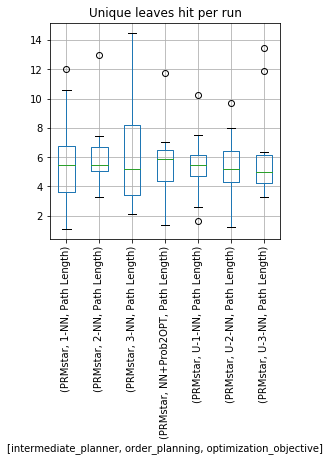

In [7]:
(data_df.unique_leaves_collided / data_df.targets_visited)\
    .to_frame()\
    .boxplot(by=['intermediate_planner','order_planning', 'optimization_objective'], rot=90, figsize=(4,4))

plt.title('Unique leaves hit per run')
plt.suptitle('')
plt.savefig('leaves_hit_per_target.png')
plt.show()

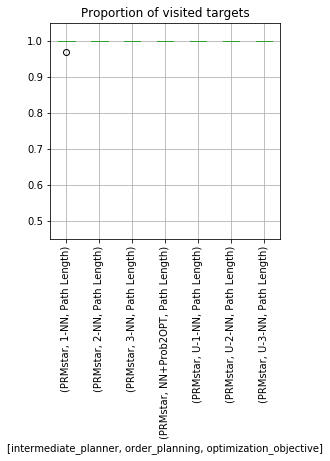

In [8]:
(data_df.targets_visited/ data_df.apples)\
    .to_frame()\
    .boxplot(by=['intermediate_planner','order_planning', 'optimization_objective'], rot=90, figsize=(4,4))

plt.ylim(0.45,1.05)
plt.title('Proportion of visited targets')
plt.suptitle('')
plt.savefig('proportion_visited_targets.png')
plt.show()